In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('wine').getOrCreate()

In [26]:
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,DoubleType)

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv")
col=redData.columns

data_schema = [StructField(col[0],DoubleType(),True),
              StructField(col[1],DoubleType(),True),
              StructField(col[2],DoubleType(),True),
              StructField(col[3],DoubleType(),True),
              StructField(col[4],DoubleType(),True),
              StructField(col[5],DoubleType(),True),
              StructField(col[6],DoubleType(),True),
              StructField(col[7],DoubleType(),True),
              StructField(col[8],DoubleType(),True),
              StructField(col[9],DoubleType(),True),
              StructField(col[10],DoubleType(),True),
              StructField(col[11],IntegerType(),True)]
final_struct = StructType(fields=data_schema)

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv", schema=final_struct)
whiteData = spark.read.format("csv").option("header", "true").load("./data/winequality-white.csv", schema=final_struct)


from pyspark.sql.functions import lit

redData=redData.withColumn("color", lit('red'))
whiteData=whiteData.withColumn("color", lit('white'))

combinedData = redData.union(whiteData)
col=combinedData.columns

In [28]:
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns: "label" and "features".

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

qualityModelsDf = alcoholContentModelDf = combinedData.select(col[0:12])
colorModelDf = combinedData.select('fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol',
           'color')

# Combine all features into one vector named features.
assembler = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
              outputCol="features")

# Let's transform the data. 
outputQuality = assembler.transform(qualityModelsDf)

# Let's import the string indexer (similar to the logistic regression exercises).
from pyspark.ml.feature import StringIndexer

indexerQuality = StringIndexer(inputCol=col[11], outputCol="QualityIndex")
output_fixed_quality = indexerQuality.fit(outputQuality).transform(outputQuality)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
final_data_quality = output_fixed_quality.select("features",'QualityIndex')

# Split the training and testing set.
train_data_quality,test_data_quality = final_data_quality.randomSplit([0.8,0.2])


#Alcohol

# Combine all features into one vector named features.
assembler = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'quality'],
              outputCol="features")

# Let's transform the data. 
outputAlcohol = assembler.transform(alcoholContentModelDf)


final_data_alcohol = outputAlcohol.select("features",'alcohol')

# Split the training and testing set.
train_data_alcohol,test_data_alcohol = final_data_alcohol.randomSplit([0.8,0.2])


#Color

assembler = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
              outputCol="features")

# Let's transform the data. 
outputColor = assembler.transform(colorModelDf)

# Let's import the string indexer (similar to the logistic regression exercises).
from pyspark.ml.feature import StringIndexer

indexerColor = StringIndexer(inputCol=col[12], outputCol="ColorIndex")
output_fixed_color = indexerColor.fit(outputColor).transform(outputColor)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
final_data_color = output_fixed_color.select("features",'ColorIndex')

# Split the training and testing set.
train_data_color,test_data_color = final_data_color.randomSplit([0.8,0.2])


Start of Dirty Data Anylsis

In [14]:
redDirtyData = spark.read.format("csv").option("header", "true").load("./data/winequality-red - Dirty.csv", schema=final_struct)
whiteDirtyData = spark.read.format("csv").option("header", "true").load("./data/winequality-white - Dirty.csv", schema=final_struct)

# Add variable for wine color
redDirtyData=redDirtyData.withColumn("color", lit('red'))
whiteDirtyData=whiteDirtyData.withColumn("color", lit('white'))

combinedDataDirty = redDirtyData.union(whiteDirtyData)

colDirty = combinedDataDirty.columns

In [18]:
print("Before NA Remove: ")
for column in colDirty:
    print(str(column) +" " + str(combinedDataDirty.select(column).count()))
combinedDataDirty=combinedDataDirty.na.drop()
print("")
print("After NA Remove: ")
for column in colDirty:
    print(str(column) +" " + str(combinedDataDirty.select(column).count()))

Before NA Remove: 
fixed acidity 6497
volatile acidity 6497
citric acid 6497
residual sugar 6497
chlorides 6497
free sulfur dioxide 6497
total sulfur dioxide 6497
density 6497
pH 6497
sulphates 6497
alcohol 6497
quality 6497
color 6497

After NA Remove: 
fixed acidity 6406
volatile acidity 6406
citric acid 6406
residual sugar 6406
chlorides 6406
free sulfur dioxide 6406
total sulfur dioxide 6406
density 6406
pH 6406
sulphates 6406
alcohol 6406
quality 6406
color 6406


In [19]:
print(combinedDataDirty.describe(col[0:5]).show())
print(combinedDataDirty.describe(col[5:10]).show())
print(combinedDataDirty.describe(col[10:]).show())

+-------+------------------+-------------------+-------------------+------------------+--------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|
+-------+------------------+-------------------+-------------------+------------------+--------------------+
|  count|              6406|               6406|               6406|              6406|                6406|
|   mean|7.2095769591008345|0.33910318451451826| 0.3187839525444844| 6.220465188885428|0.055971901342491366|
| stddev|1.2933333506498128| 0.1642307418847679|0.14528092090220357|25.259236852529188| 0.03518619358397865|
|    min|               3.8|               0.08|                0.0|               0.6|               0.009|
|    max|              15.9|               1.58|               1.66|             999.0|               0.611|
+-------+------------------+-------------------+-------------------+------------------+--------------------+

None
+-------+----

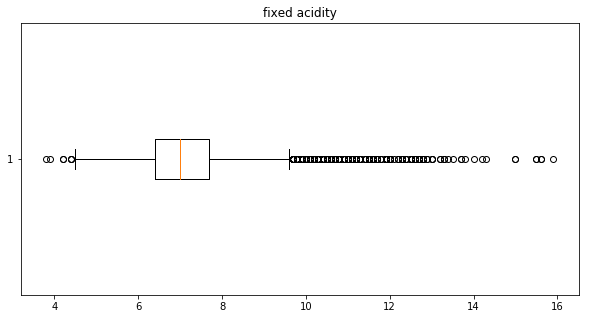

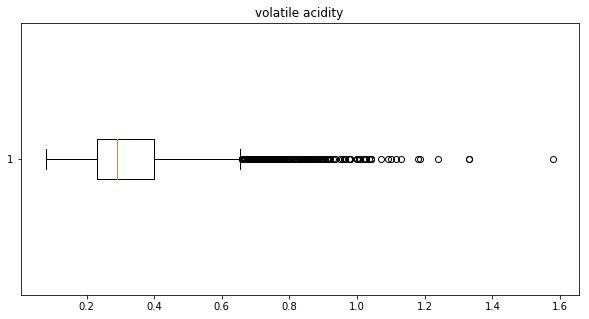

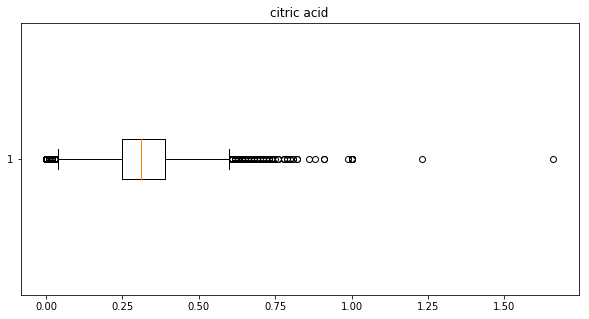

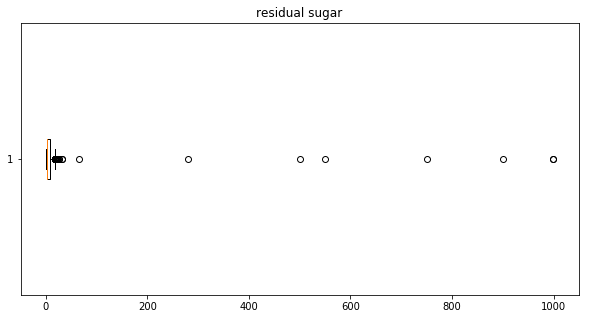

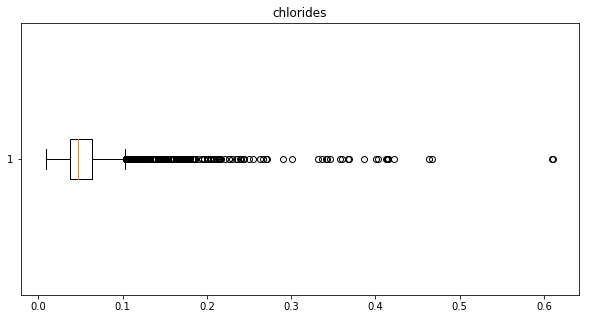

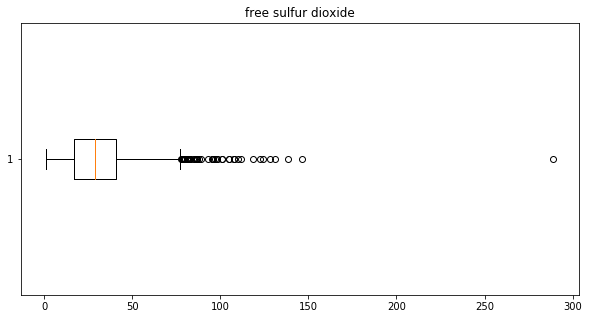

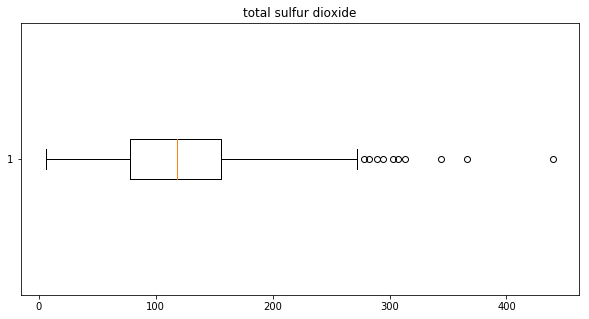

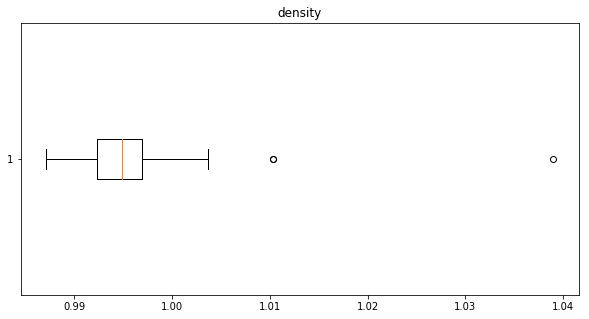

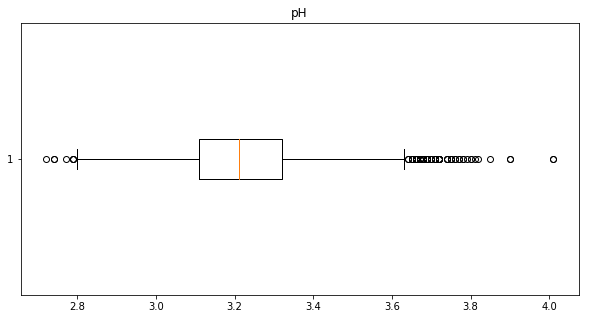

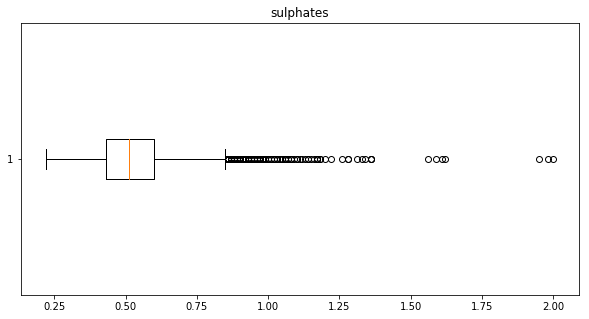

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

for column in colDirty[0:10]:
    fig1, ax1 = plt.subplots()
    ax1.set_title(column)
    plt.boxplot(x=np.asarray(combinedDataDirty.select(column).collect()),vert=False)

{'boxes': [<matplotlib.lines.Line2D at 0x7ff1ef2690b8>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff1ef269ac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff1ef26f780>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff1ef26f358>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff1ef269208>,
  <matplotlib.lines.Line2D at 0x7ff1ef2696a0>]}

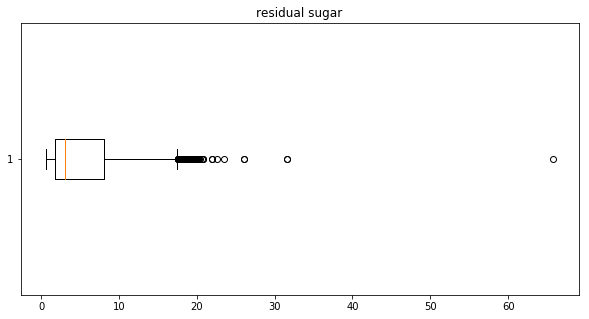

In [23]:
combinedDataDirty=combinedDataDirty.filter(combinedDataDirty["residual sugar"]<200)
fig1, ax1 = plt.subplots()
ax1.set_title("residual sugar")
plt.boxplot(x=np.asarray(combinedDataDirty.select("residual sugar").collect()),vert=False)